### 1 导入包 

In [1]:

from collections import defaultdict

import matplotlib.pyplot as plt
# 常用包
import numpy as np
import pandas as pd
import seaborn as sns
# 导入torch
import torch
import torch.nn.functional as F
from pylab import rcParams
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from torch import nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
# 导入transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

%matplotlib inline
%config InlineBackend.figure_format='retina' # 主题

In [2]:
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
torch.cuda.is_available()

True

### 2 加载数据

In [4]:
with open('data/train_dataset_v2.tsv', 'r', encoding='utf-8') as handler:
    lines = handler.read().split('\n')[1:-1]

    data = list()
    for line in tqdm(lines):
        sp = line.split('\t')
        if len(sp) != 4:
            print("ERROR:", sp)
            continue
        data.append(sp)

train = pd.DataFrame(data)
train.columns = ['id', 'content', 'character', 'emotions']

test = pd.read_csv('data/test_dataset.tsv', sep='\t')
submit = pd.read_csv('data/submit_example.tsv', sep='\t')
train = train[train['emotions'] != '']

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42790/42790 [00:00<00:00, 1068986.42it/s]


### 3 数据预处理处理

### 3.1 文本拼接

In [5]:
train['text'] = ' 内容: ' + train[ 'content'].astype(str)  +'角色: ' + train['character'].astype(str)
test['text'] ='内容: ' + test['content'].astype(str) + ' 内容: ' + test['character'].astype(str)

### 3.2  标签转换

In [6]:
train['emotions'] = train['emotions'].apply(lambda x: [int(_i) for _i in x.split(',')])

train[['love', 'joy', 'fright', 'anger', 'fear', 'sorrow']] = train['emotions'].values.tolist()

In [7]:
test[['love', 'joy', 'fright', 'anger', 'fear', 'sorrow']] =[0,0,0,0,0,0]

In [8]:
train['love'].value_counts()

0    35500
1      527
3      409
2      346
Name: love, dtype: int64

In [9]:
train.head()

,id,content,character,emotions,text,love,joy,fright,anger,fear,sorrow
0,1171_0001_A_1,天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。,o2,"[0, 0, 0, 0, 0, 0]",内容: 天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。...,0,0,0,0,0,0
1,1171_0001_A_2,天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。,c1,"[0, 0, 0, 0, 0, 0]",内容: 天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。...,0,0,0,0,0,0
2,1171_0001_A_3,o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。,o2,"[0, 0, 0, 0, 0, 0]",内容: o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。角色: o2,0,0,0,0,0,0
3,1171_0001_A_4,o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。,c1,"[0, 0, 0, 0, 0, 0]",内容: o2一手拿着一个行李，一路小跑着把c1带到了文工团门口。角色: c1,0,0,0,0,0,0
4,1171_0001_A_5,o2停下来接过c1手里的行李：你妈妈交待我了，等领了军装一定要照张相寄回去，让街坊邻居都知道...,o2,"[0, 0, 0, 0, 0, 0]",内容: o2停下来接过c1手里的行李：你妈妈交待我了，等领了军装一定要照张相寄回去，让街坊...,0,0,0,0,0,0


###  4 认识Tokenizer
> Byte Pair Encoding（BPE）/WordPiece

### 4.1 将文本映射为id表示

In [10]:
PRE_TRAINED_MODEL_NAME = 'hfl/chinese-roberta-wwm-ext'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [11]:
tokenizer

PreTrainedTokenizer(name_or_path='hfl/chinese-roberta-wwm-ext', vocab_size=21128, model_max_len=1000000000000000019884624838656, is_fast=False, padding_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

- 可以看到`BertTokenizer`的词表大小为21128
- 特殊符号为`special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}`

我们尝试使用`BertTokenizer`进行分词


In [12]:
train['text'][0]

' 内容: 天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。角色: o2'

In [13]:
sample_txt = '内容: 天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。角色: o2'

In [14]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'文本为: {sample_txt}')
print(f'分词的列表为: {tokens}')
print(f'词对应的唯一id: {token_ids}')

文本为: 内容: 天空下着暴雨，o2正在给c1穿雨衣，他自己却只穿着单薄的军装，完全暴露在大雨之中。角色: o2
分词的列表为: ['内', '容', ':', '天', '空', '下', '着', '暴', '雨', '，', 'o', '##2', '正', '在', '给', 'c1', '穿', '雨', '衣', '，', '他', '自', '己', '却', '只', '穿', '着', '单', '薄', '的', '军', '装', '，', '完', '全', '暴', '露', '在', '大', '雨', '之', '中', '。', '角', '色', ':', 'o', '##2']
词对应的唯一id: [1079, 2159, 131, 1921, 4958, 678, 4708, 3274, 7433, 8024, 157, 8144, 3633, 1762, 5314, 10905, 4959, 7433, 6132, 8024, 800, 5632, 2346, 1316, 1372, 4959, 4708, 1296, 5946, 4638, 1092, 6163, 8024, 2130, 1059, 3274, 7463, 1762, 1920, 7433, 722, 704, 511, 6235, 5682, 131, 157, 8144]


### 4.2 特殊符号

In [15]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [16]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [17]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [18]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [19]:
tokenizer.mask_token, tokenizer.mask_token_id

('[MASK]', 103)

可以使用 encode_plus() 对句子进行分词，添加特殊符号

In [20]:
encoding=tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    add_special_tokens=True,# [CLS]和[SEP]
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',# Pytorch tensor张量

)
encoding.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
E:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [21]:
encoding

{'input_ids': tensor([[  101,  1079,  2159,   131,  1921,  4958,   678,  4708,  3274,  7433,
          8024,   157,  8144,  3633,  1762,  5314, 10905,  4959,  7433,  6132,
          8024,   800,  5632,  2346,  1316,  1372,  4959,  4708,  1296,  5946,
          4638,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}

token ids的长度为32的张量

In [22]:
print(len(encoding['input_ids'][0]))

32


attention mask具有同样的长度

In [23]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])

我们将ids反转为词语，可以打印下每个字符是什么？

In [24]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 '内',
 '容',
 ':',
 '天',
 '空',
 '下',
 '着',
 '暴',
 '雨',
 '，',
 'o',
 '##2',
 '正',
 '在',
 '给',
 'c1',
 '穿',
 '雨',
 '衣',
 '，',
 '他',
 '自',
 '己',
 '却',
 '只',
 '穿',
 '着',
 '单',
 '薄',
 '的',
 '[SEP]']

### 4.2 选取文本最大长度

In [25]:
token_lens = []

for txt in tqdm(train.text):
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36782/36782 [00:11<00:00, 3175.47it/s]


E:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


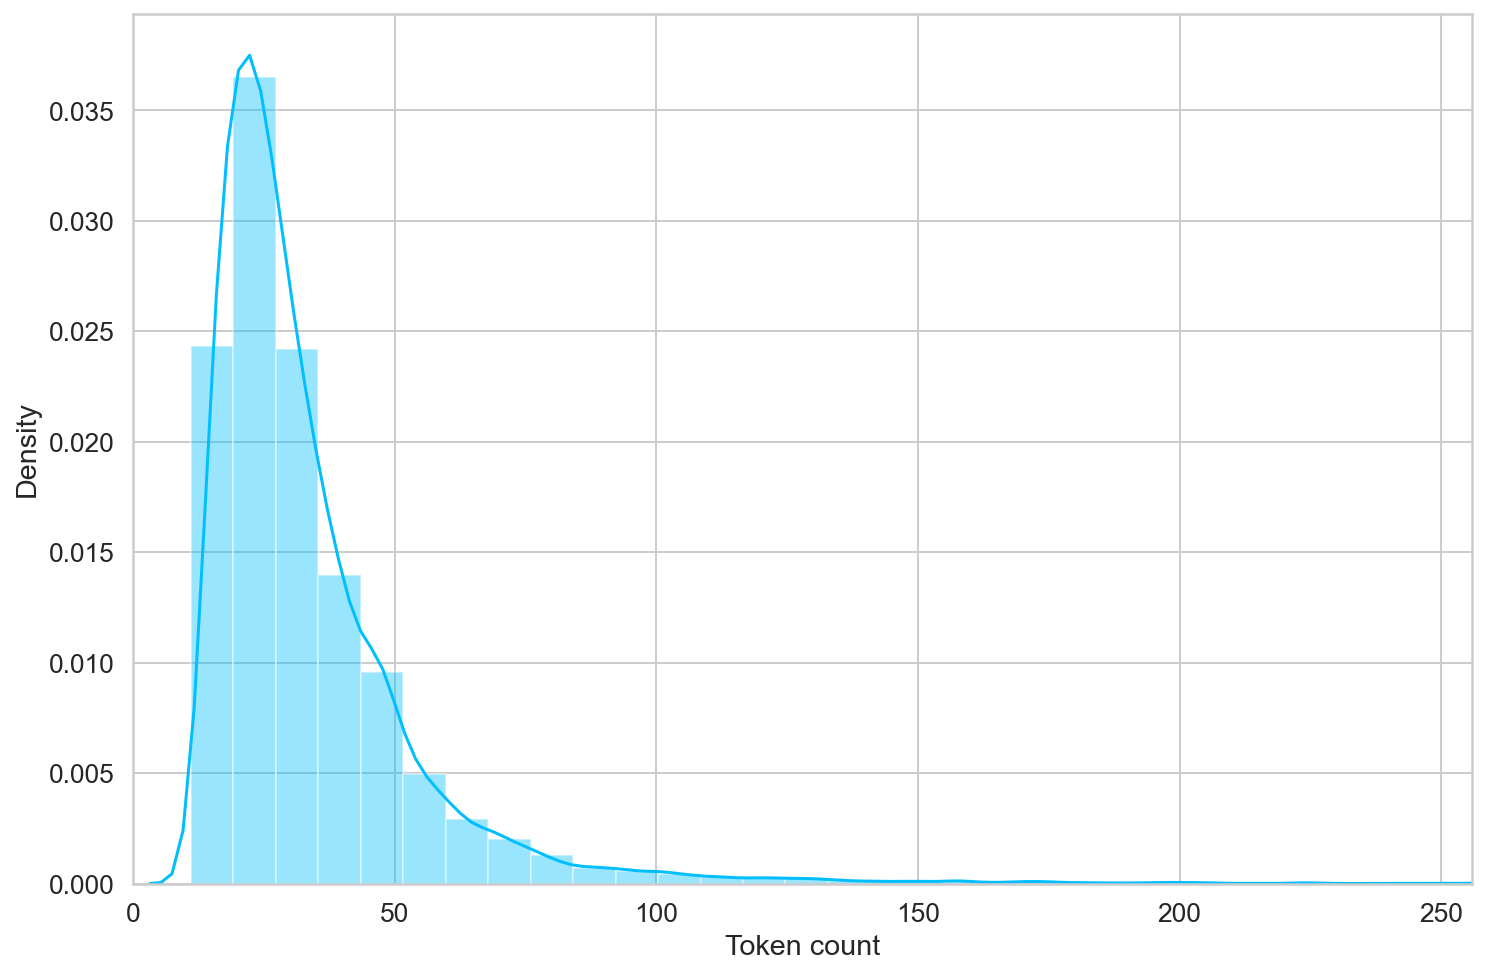

In [26]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

可以看到大多数文本的ids长度在300我们设置最大长度为300

In [27]:
pd.Series(token_lens).describe()

count    36782.000000
mean        33.464194
std         21.365152
min         11.000000
25%         21.000000
50%         28.000000
75%         39.000000
max        417.000000
dtype: float64

In [28]:
# token_lens = []

# for txt in tqdm(train.):
#     tokens = tokenizer.encode(txt, max_length=512)
#     token_lens.append(len(tokens))
    
# pd.Series(token_lens).describe()

In [29]:
MAX_LEN=128

### 5 构建学术论文数据集

In [30]:
target_cols=['love', 'joy', 'fright', 'anger', 'fear', 'sorrow']

### 5.1 自定义数据集

In [31]:
class RoleDataset(Dataset):
    def __init__(self,texts,labels,tokenizer,max_len):
        self.texts=texts
        self.labels=labels
        self.tokenizer=tokenizer
        self.max_len=max_len
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self,item):
        """
        item 为数据索引，迭代取第item条数据
        """
        text=str(self.texts[item])
        label=self.labels[item]
        
        encoding=self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=True,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
#         print(encoding['input_ids'])
        sample = {
            'texts': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }
        for label_col in target_cols:
            sample[label_col] = torch.tensor(label[label_col], dtype=torch.float)
        return sample
        

### 5.2 划分数据集并创建生成器

In [32]:
df_train, df_val = train_test_split(train, test_size=0.1, random_state=RANDOM_SEED)
# df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)
# df_train.shape, df_val.shape, df_test.shape

In [33]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds=RoleDataset(
        texts=df['text'].values,
        labels=df[target_cols].to_dict('records'),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
#         num_workers=4 # windows多线程
    )

In [34]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
# test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [35]:
next(iter(train_data_loader))

E:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


{'texts': [' 内容: t2走到f3博士面前，去他的脖子前寻找着，但f3博士却用仅存的力气护着自己的项链。角色: t2',
  ' 内容: f2c1端着菜出来，f2e1正在收拾桌子上的东西。f2推门回来。角色: c1',
  ' 内容: 门重重打开，脱了行头的b1从门里走了出来。角色: b1',
  ' 内容: j1：人还在吗？角色: j1',
  ' 内容: p2：大家好！我虽然站在这里，但是，我不是今天葬礼的主持人，应m2生前的要求，主持人会是她自己。角色: p2',
  ' 内容: r1用山河社稷图收了i2：没费功夫。角色: i2',
  ' 内容: a1直起身子看着o2，叹了一口气。角色: o2',
  ' 内容: b1：还是没反应。角色: b1',
  ' 内容: t2转身：因为你是白居易，因为三十年过去了，仍然心系贵妃的只有你。角色: t2',
  ' 内容: r2和z2都松了一口气。角色: r2',
  ' 内容: w2抄起话筒：FU569，复飞，FU569，请立即复飞，跑道上有障碍。角色: w2',
  ' 内容: s2：没她电话。角色: s2',
  ' 内容: 连t2：是，赶紧签了吧，（翻开材料）来。角色: t2',
  ' 内容: h1起哄：是啊。角色: h1',
  ' 内容: a1：你放心，你的猪脑我另作他用。角色: a1',
  ' 内容: m2很失落，这时，电话响了，显示“你妈”。角色: m2'],
 'input_ids': tensor([[ 101, 1079, 2159,  ...,    0,    0,    0],
         [ 101, 1079, 2159,  ...,    0,    0,    0],
         [ 101, 1079, 2159,  ...,    0,    0,    0],
         ...,
         [ 101, 1079, 2159,  ...,    0,    0,    0],
         [ 101, 1079, 2159,  ...,    0,    0,    0],
         [ 101, 1079, 2159,  ...,    0,    0,    0]]),
 'attention_mask': tens

In [36]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['texts', 'input_ids', 'attention_mask', 'love', 'joy', 'fright', 'anger', 'fear', 'sorrow'])

In [37]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['love'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


## 6 基于Huggingface 的学术论文分类模型构建

![](https://pic1.zhimg.com/80/v2-edafe957e971fe53feeadd2477706cf4_720w.jpg)

In [38]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
bert_model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(21128, 768, padding_idx=1)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

![](https://jalammar.github.io/images/t/transformer_resideual_layer_norm_2.png)

In [40]:
encoding

{'input_ids': tensor([[  101,  1079,  2159,   131,  1921,  4958,   678,  4708,  3274,  7433,
          8024,   157,  8144,  3633,  1762,  5314, 10905,  4959,  7433,  6132,
          8024,   800,  5632,  2346,  1316,  1372,  4959,  4708,  1296,  5946,
          4638,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1]])}

In [41]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'], 
    attention_mask=encoding['attention_mask'],
    return_dict = False
)

In [42]:
last_hidden_state

tensor([[[-0.0025,  0.6479,  0.7143,  ..., -0.7188, -0.2598, -0.5084],
         [ 0.3467, -0.0880,  1.6548,  ..., -0.5540, -0.7437, -0.2925],
         [ 1.3818, -1.1031,  1.3446,  ..., -0.5718,  0.0648, -0.0850],
         ...,
         [ 0.6574, -0.1395, -0.3851,  ...,  0.0146, -0.5648, -1.0349],
         [ 0.2467,  0.4570, -0.1530,  ..., -0.2101,  0.2632, -1.0407],
         [-0.0025,  0.6479,  0.7143,  ..., -0.7188, -0.2598, -0.5084]]],
       grad_fn=<NativeLayerNormBackward>)

In [43]:
last_hidden_state.shape # 

torch.Size([1, 32, 768])

1 条样本 32个token 768维向量

In [44]:
bert_model.config.hidden_size

768

In [45]:
pooled_output.shape
# 整体句子表示

torch.Size([1, 768])

### 定义分类模型

In [46]:
class EmotionClassifier(nn.Module):
    def __init__(self, n_classes):
        super(EmotionClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.out_love = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out_joy = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out_fright = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out_anger = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out_fear = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.out_sorrow = nn.Linear(self.bert.config.hidden_size, n_classes)
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict = False
        )
        love = self.out_love(pooled_output)
        joy = self.out_joy(pooled_output)
        fright = self.out_fright(pooled_output)
        anger = self.out_anger(pooled_output)
        fear = self.out_fear(pooled_output)
        sorrow = self.out_sorrow(pooled_output)
        return {
            'love': love, 'joy': joy, 'fright': fright,
            'anger': anger, 'fear': fear, 'sorrow': sorrow,
        }

In [47]:
# class_names=train.love.unique()
class_names=[1]

In [48]:
model = EmotionClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [49]:
data

{'texts': [' 内容: t2走到f3博士面前，去他的脖子前寻找着，但f3博士却用仅存的力气护着自己的项链。角色: t2',
  ' 内容: f2c1端着菜出来，f2e1正在收拾桌子上的东西。f2推门回来。角色: c1',
  ' 内容: 门重重打开，脱了行头的b1从门里走了出来。角色: b1',
  ' 内容: j1：人还在吗？角色: j1',
  ' 内容: p2：大家好！我虽然站在这里，但是，我不是今天葬礼的主持人，应m2生前的要求，主持人会是她自己。角色: p2',
  ' 内容: r1用山河社稷图收了i2：没费功夫。角色: i2',
  ' 内容: a1直起身子看着o2，叹了一口气。角色: o2',
  ' 内容: b1：还是没反应。角色: b1',
  ' 内容: t2转身：因为你是白居易，因为三十年过去了，仍然心系贵妃的只有你。角色: t2',
  ' 内容: r2和z2都松了一口气。角色: r2',
  ' 内容: w2抄起话筒：FU569，复飞，FU569，请立即复飞，跑道上有障碍。角色: w2',
  ' 内容: s2：没她电话。角色: s2',
  ' 内容: 连t2：是，赶紧签了吧，（翻开材料）来。角色: t2',
  ' 内容: h1起哄：是啊。角色: h1',
  ' 内容: a1：你放心，你的猪脑我另作他用。角色: a1',
  ' 内容: m2很失落，这时，电话响了，显示“你妈”。角色: m2'],
 'input_ids': tensor([[ 101, 1079, 2159,  ...,    0,    0,    0],
         [ 101, 1079, 2159,  ...,    0,    0,    0],
         [ 101, 1079, 2159,  ...,    0,    0,    0],
         ...,
         [ 101, 1079, 2159,  ...,    0,    0,    0],
         [ 101, 1079, 2159,  ...,    0,    0,    0],
         [ 101, 1079, 2159,  ...,    0,    0,    0]]),
 'attention_mask': tens

In [50]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 128])
torch.Size([16, 128])


In [51]:
model(input_ids, attention_mask)

{'love': tensor([[0.2361],
         [0.4023],
         [0.1668],
         [0.3457],
         [0.3589],
         [0.1501],
         [0.3664],
         [0.2018],
         [0.3113],
         [0.0846],
         [0.0941],
         [0.2613],
         [0.3184],
         [0.2400],
         [0.1404],
         [0.3542]], device='cuda:0', grad_fn=<AddmmBackward>),
 'joy': tensor([[-0.2712],
         [-0.2420],
         [-0.2039],
         [-0.6243],
         [-0.4878],
         [-0.1832],
         [-0.4548],
         [-0.4827],
         [-0.1782],
         [-0.2750],
         [-0.4762],
         [-0.4199],
         [-0.4789],
         [-0.5245],
         [-0.4799],
         [-0.5356]], device='cuda:0', grad_fn=<AddmmBackward>),
 'fright': tensor([[0.1903],
         [0.2220],
         [0.2341],
         [0.1877],
         [0.2477],
         [0.3106],
         [0.3565],
         [0.2665],
         [0.2346],
         [0.4124],
         [0.1846],
         [0.2451],
         [0.3428],
         [0.3472

## 7 模型训练

In [52]:
EPOCHS = 1 # 训练轮数

optimizer = AdamW(model.parameters(), lr=3e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.MSELoss().to(device)

In [53]:
def train_epoch(
  model, 
  data_loader, 
  criterion, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for sample in tqdm(data_loader):
        input_ids = sample["input_ids"].to(device)
        attention_mask = sample["attention_mask"].to(device)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        loss_love = criterion(outputs['love'], sample['love'].to(device))
        loss_joy = criterion(outputs['joy'], sample['joy'].to(device))
        loss_fright = criterion(outputs['fright'], sample['fright'].to(device))
        loss_anger = criterion(outputs['anger'], sample['anger'].to(device))
        loss_fear = criterion(outputs['fear'], sample['fear'].to(device))
        loss_sorrow = criterion(outputs['sorrow'], sample['sorrow'].to(device))
        loss = loss_love + loss_joy + loss_fright + loss_anger + loss_fear + loss_sorrow
        
        
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
#     return correct_predictions.double() / (n_examples*6), np.mean(losses)
    return np.mean(losses)

In [54]:
def eval_model(model, data_loader, criterion, device, n_examples):
    model = model.eval() # 验证预测模式

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for sample in tqdm(data_loader):
            input_ids = sample["input_ids"].to(device)
            attention_mask = sample["attention_mask"].to(device)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            loss_love = criterion(outputs['love'], sample['love'].to(device))
            loss_joy = criterion(outputs['joy'], sample['joy'].to(device))
            loss_fright = criterion(outputs['fright'], sample['fright'].to(device))
            loss_anger = criterion(outputs['anger'], sample['anger'].to(device))
            loss_fear = criterion(outputs['fear'], sample['fear'].to(device))
            loss_sorrow = criterion(outputs['sorrow'], sample['sorrow'].to(device))
            loss = loss_love + loss_joy + loss_fright + loss_anger + loss_fear + loss_sorrow


            losses.append(loss.item())
    return  np.mean(losses)


In [57]:

history = defaultdict(list) # 记录10轮loss和acc
best_loss = float('inf')

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

#     train_loss = train_epoch(
#         model,
#         train_data_loader,
#         loss_fn,
#         optimizer,
#         device,
#         scheduler,
#         len(df_train)
#     )

    print(f'Train loss {train_loss}')

    val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f'Val   loss {val_loss} ')
    print()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    if val_loss < best_loss:
        torch.save(model.state_dict(), 'best_model_state.bin')


  0%|                                                                                                                                                                                                                                                     | 0/230 [00:00<?, ?it/s]

Epoch 1/1
----------
Train loss 1.464792532793216


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 230/230 [00:06<00:00, 33.12it/s]


Val   loss 1.528440403096054 



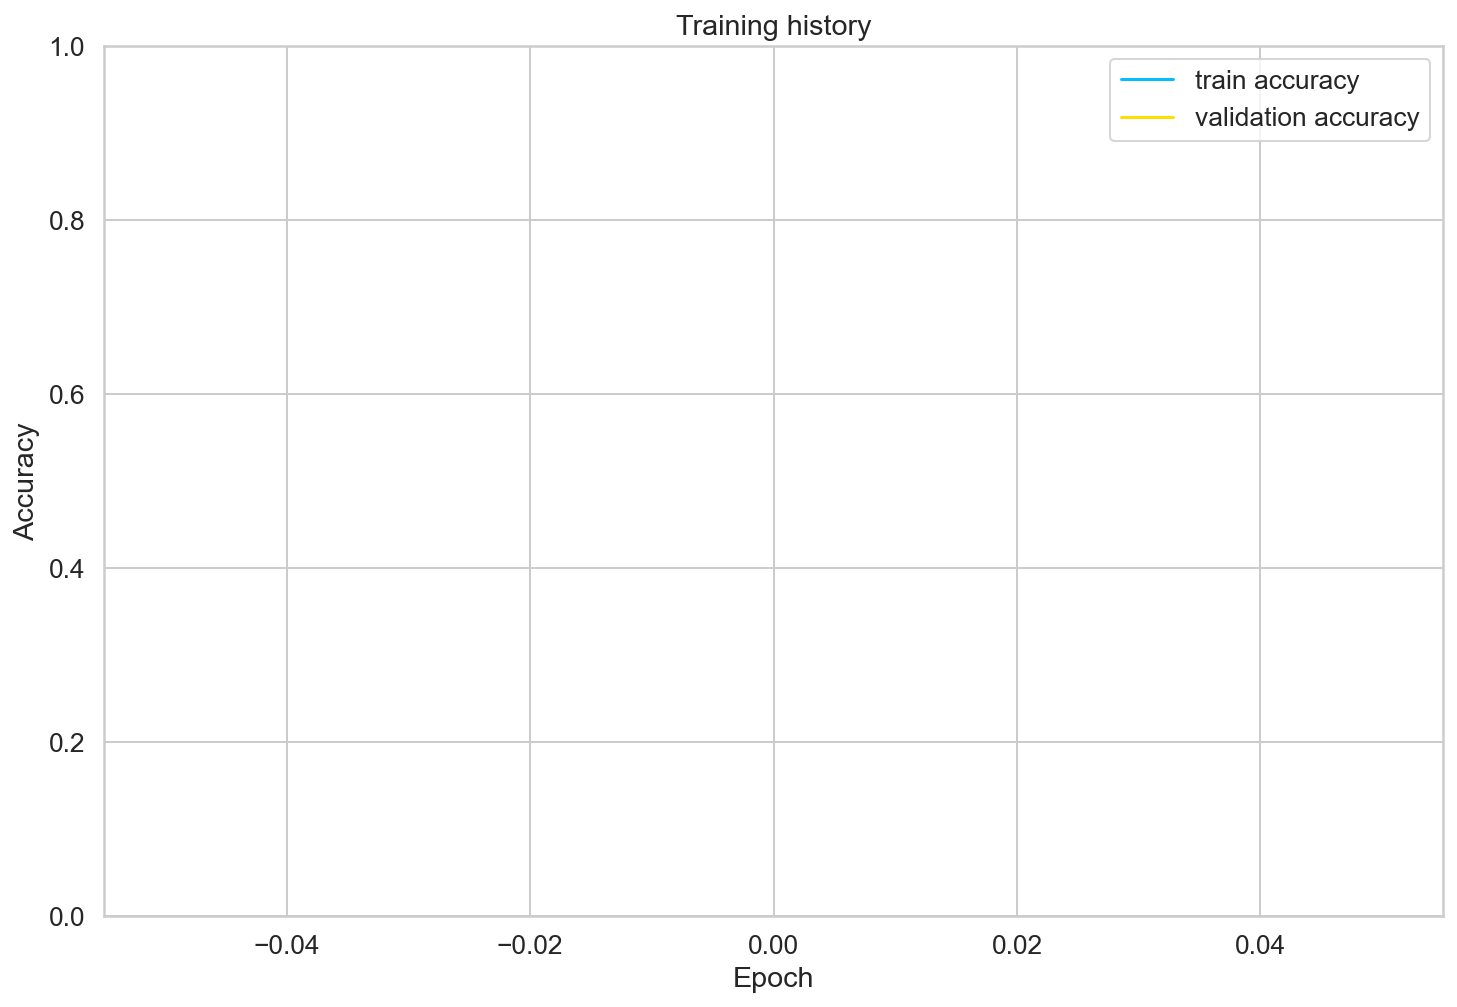

In [58]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

## 8 模型预测

In [59]:
test_data_loader = create_data_loader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [64]:
def predict(model):
    val_loss = 0
    test_pred = defaultdict(list)
    model.eval()
    for step, batch in tqdm(enumerate(test_data_loader)):
        b_input_ids = batch['input_ids'].to(device)
        b_attention_mask = batch['attention_mask'].to(device)

        with torch.no_grad():
            logits = model(input_ids=b_input_ids, attention_mask=b_attention_mask)
            for col in target_cols:
                test_pred[col].append(logits[col].to('cpu').numpy())
    preds = {}
    for col in target_cols:
        print(len(np.concatenate(test_pred[col])))
        preds[col] = (np.concatenate(test_pred[col]))
    return preds

submit = pd.read_csv('data/submit_example.tsv', sep='\t')

best_model = EmotionClassifier(len(class_names))
path = f'best_model_state.bin'
best_model.load_state_dict(torch.load(path))
best_model.to(device)
test_pred = predict(best_model)


Some weights of the model checkpoint at hfl/chinese-roberta-wwm-ext were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
0it [00:00, ?it/s]E:\ProgramData\Anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length`

21376
21376
21376
21376
21376
21376


In [66]:
label_preds = []
for col in target_cols:
    preds = test_pred[col]
    label_preds.append(preds.flatten())
sub = submit.copy()
sub['emotion'] = np.stack(label_preds, axis=1).tolist()
sub['emotion'] = sub['emotion'].apply(lambda x: ','.join([str(i) for i in x]))
sub.head()

,id,emotion
0,34170_0002_A_12,"0.05773647874593735,0.08950565755367279,0.0876..."
1,34170_0002_A_14,"0.056820206344127655,0.0903855413198471,0.0870..."
2,34170_0003_A_16,"0.056235916912555695,0.0906827300786972,0.0863..."
3,34170_0003_A_17,"0.060653604567050934,0.09047575294971466,0.087..."
4,34170_0003_A_18,"0.06049662083387375,0.09141705930233002,0.0872..."


In [67]:
sub.to_csv(f'baseline.tsv', sep='\t', index=False)

In [ ]:
# 0.67+

## ChallengeHub

分享人：致Great ChallengeHub成员 中国人民大学硕士

![](https://img-blog.csdnimg.cn/fcef57e247724f02bf84533e13cfa523.jpg)

关注回复**“爱奇艺”** 获取本notebook